# Understanding Student Dropout Trends: An Exploratory Analysis

<img src="./drop_sc.png" alt="Image description" width="700">


## 1.Business Understanding


### This project delves into the multifaceted issue of student dropout rates, aiming to uncover the key factors that influence a student's decision to leave school prematurely. This analysis explores four dimensions including family factors, financial and economics, application support, and education engagement. Data is gathered from Kaggle (https://www.kaggle.com/datasets/naveenkumar20bps1137/predict-students-dropout-and-academic-success?select=dataset.csv)  and the goal is that the methodologies demonstrated here—ranging from exploratory data analysis and statistical testing to predictive modeling—showcase a reproducible framework for educational data mining. By providing insights into the complex interplay of factors affecting student retention, this project could serve as a valuable resource for educators, policymakers, and researchers aiming to develop targeted.


1. Does marital status contribute to student Dropout Rates?
2. Are international students less or more likely of Dropping Out?
3. Does parental education prevent Dropout?
4. How does gender relate to Student Dropout?

## 2.Data Understanding

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

### Exploratory Data Analysis (EDA)

In [36]:
df = pd.read_csv('./dataset.csv')
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [37]:
print("This dataset has {} rows and {} columns".format(df.shape[0],df.shape[1]))

This dataset has 4424 rows and 35 columns


In [38]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

### Standardizing column names with snake_notation 

In [39]:

df.columns = df.columns.str.replace(' ', '_')

### Looking for missing values

In [40]:
print("There are {} columns wiht missing data.".format(len((df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0])))

There are 0 columns wiht missing data.


In [41]:
#(df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0]


In [42]:
# missing_percentage = (df.isnull().mean() * 100)[df.isnull().mean() * 100 > 0].sort_values(ascending=False)
# missing_percentage.plot(kind='barh', color='blue')
# plt.title('Percentage of Missing Values by Column')
# plt.xlabel('Percentage (%)')
# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.grid(axis='x')
# plt.show()

### Exploring target feature

In [44]:
df['Target'].value_counts(normalize=True)

Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

### Isolating categorical features

In [45]:
df.select_dtypes(include='object').columns

Index(['Target'], dtype='object')

In [46]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(include='object').columns)))

At a first glance, there are 1 categorical features.


### However, looking at the dataset schema provided some features like Marital Status, Application Mode, Course, Daytime/Evening Attendance,  Nationality, Mother's Qualification, Father's Qualification, Mother's Occupation, Father's Occupation, Displaced, Educational Special Needs, Debtor, Tuition Fees Up To Date, Gender, Scholarship Holder, International are categorical. Thus, these subset would need to be converteted to category.

In [47]:
cat_feat = ['Marital_status', 'Application_mode', 'Application_order', 'Course', 'Daytime/evening_attendance', 'Previous_qualification', 'Nacionality', "Mother's_qualification", 
            "Father's_qualification", "Mother's_occupation", "Father's_occupation", 'Displaced', 'Educational_special_needs',
            'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'Age_at_enrollment', 'International']

In [48]:
# Convert the 'Marital_status' column to category without mapping
df[cat_feat] = df[cat_feat].astype('category')

print(df.dtypes)


Marital_status                                    category
Application_mode                                  category
Application_order                                 category
Course                                            category
Daytime/evening_attendance                        category
Previous_qualification                            category
Nacionality                                       category
Mother's_qualification                            category
Father's_qualification                            category
Mother's_occupation                               category
Father's_occupation                               category
Displaced                                         category
Educational_special_needs                         category
Debtor                                            category
Tuition_fees_up_to_date                           category
Gender                                            category
Scholarship_holder                                catego

In [49]:
print("After a review, there is {} object type features.".format(len(df.select_dtypes(include='object').columns)))

After a review, there is 1 object type features.


### Isolating quantitative features

In [50]:
df.select_dtypes(include=[('int','float64')]).columns

Index(['Curricular_units_1st_sem_(credited)',
       'Curricular_units_1st_sem_(enrolled)',
       'Curricular_units_1st_sem_(evaluations)',
       'Curricular_units_1st_sem_(approved)',
       'Curricular_units_1st_sem_(without_evaluations)',
       'Curricular_units_2nd_sem_(credited)',
       'Curricular_units_2nd_sem_(enrolled)',
       'Curricular_units_2nd_sem_(evaluations)',
       'Curricular_units_2nd_sem_(approved)',
       'Curricular_units_2nd_sem_(without_evaluations)'],
      dtype='object')

In [51]:
print("At a first glance, there are {} categorical features.".format(len(df.select_dtypes(include=[('int','float64')]).columns)))

At a first glance, there are 10 categorical features.


### Looking at summary satistics to identify possible anomalies within the quantitative features if any.

In [52]:
numeric_cols = df.select_dtypes(include=[('int','float64')]).columns
df[numeric_cols].describe()

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(without_evaluations)
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,0.709991,6.270570,8.299051,4.706600,0.137658,0.541817,6.232143,8.063291,4.435805,0.150316
std,2.360507,2.480178,4.179106,3.094238,0.690880,1.918546,2.195951,3.947951,3.014764,0.753774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,6.000000,3.000000,0.000000,0.000000,5.000000,6.000000,2.000000,0.000000
50%,0.000000,6.000000,8.000000,5.000000,0.000000,0.000000,6.000000,8.000000,5.000000,0.000000
75%,0.000000,7.000000,10.000000,6.000000,0.000000,0.000000,7.000000,10.000000,6.000000,0.000000
max,20.000000,26.000000,45.000000,26.000000,12.000000,19.000000,23.000000,33.000000,20.000000,12.000000


### Visualizing the distribution of quantitative features.

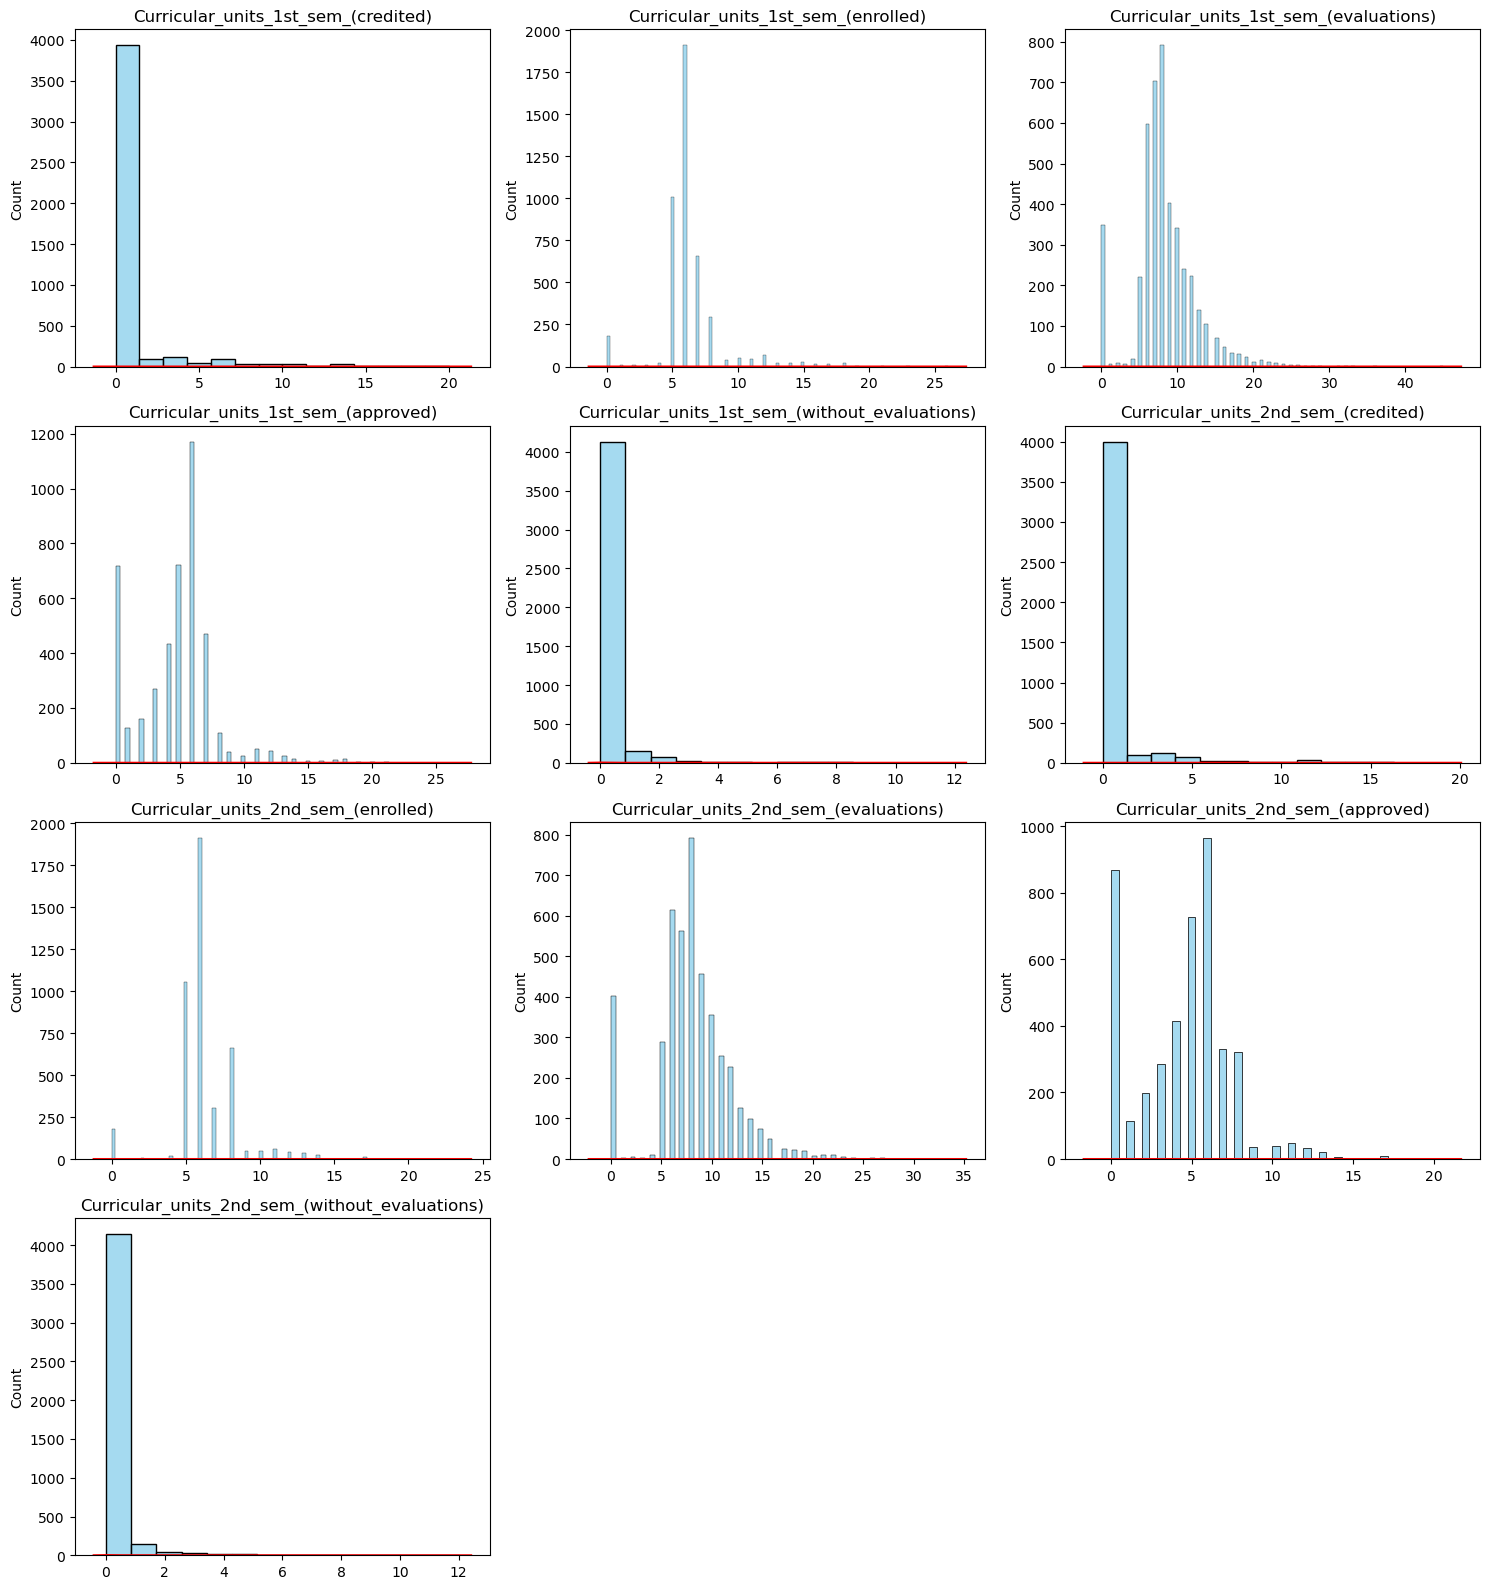

In [53]:

n_cols = 3
n_rows = (len(numeric_cols) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

# Flatten the axes array (if 2D)
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, ax=axes[i], color='skyblue')
    sns.kdeplot(data=df, x=col, ax=axes[i], color='red')
    axes[i].set_title(col)
    axes[i].set_xlabel('') 

# Remove empty axes
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

fig.tight_layout()

plt.show();


### Some of the features in the student data set present a skewed distribution; it is one where the data values are not symmetrically distributed around the mean. Instead, they tend to trail off more sharply on one side than the other. This can occur due to various factors, including the presence of extreme values or outliers, but skewness can also arise from the inherent characteristics of the data itself.


### Looking for possible outliers in quantitative features

In [54]:

def detect_outliers(df, numeric_columns):
    """
    Identify outliers in specified numerical columns of a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    numeric_columns (list): A list of column names to check for outliers.

    Returns:
    str: A message indicating the number of columns with outliers and the percentage of outliers in each column,
         or a message stating that no columns have outliers.
    """
    
    outlier_dict = {}
    outlier_listing = {}
    counter = 0
    try:
        for column in numeric_columns:
            if column in df.columns:
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
            
                # Define the outlier bounds
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
            
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
                if len(outliers)> 0:
                # Store outliers in the dictionary
                    #outlier_listing[column]  = outliers.tolist()
                    outlier_dict[column] = round(len(outliers)/df.shape[0],2)#.tolist()
                    counter +=1
                else:
                    print(f"Info: {column} has no outliers.")
    
        #if counter == 0:
         #   return "No columns have outliers."
    
        return "There are {} columns with outliers. Each columns has the following % of outliers: {}".format(counter,outlier_dict)

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [55]:
outlier_table = detect_outliers(df, numeric_cols)
print(outlier_table)

There are 10 columns with outliers. Each columns has the following % of outliers: {'Curricular_units_1st_sem_(credited)': 0.13, 'Curricular_units_1st_sem_(enrolled)': 0.1, 'Curricular_units_1st_sem_(evaluations)': 0.04, 'Curricular_units_1st_sem_(approved)': 0.04, 'Curricular_units_1st_sem_(without_evaluations)': 0.07, 'Curricular_units_2nd_sem_(credited)': 0.12, 'Curricular_units_2nd_sem_(enrolled)': 0.08, 'Curricular_units_2nd_sem_(evaluations)': 0.02, 'Curricular_units_2nd_sem_(approved)': 0.01, 'Curricular_units_2nd_sem_(without_evaluations)': 0.06}


### Looking for possible outliers in categorical features


In [56]:
import pandas as pd

def detect_categorical_outliers(df, categorical_columns, threshold=0.05):
    """
    Identify rare categories in specified categorical columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    categorical_columns (list): A list of column names to check for rare categories.
    threshold (float): The percentage threshold below which categories are considered outliers.

    Returns:
    dict: A dictionary with column names as keys and lists of rare categories as values,
          or a message stating that no rare categories were found.
    """
    outlier_dict = {}
    counter = 0
    
    try:
        for column in categorical_columns:
            if column in df.columns:

                category_counts = df[column].value_counts(normalize=True)
                
                rare_categories = category_counts[category_counts < threshold].index.tolist()
                
                if rare_categories:
                    outlier_dict[column] = rare_categories
                    counter+=1
                else:
                    print(f"Info: {column} has no outliers.")
        
        if not outlier_dict:
            return "No rare categories found in the specified columns."
        
        return "There is/are {} columns with outliers. Each columns has the following % outlier/s: {}".format(counter,outlier_dict)

    
    except Exception as e:
        return f"An error occurred: {str(e)}"



In [57]:
cat_var = df.select_dtypes(include='object').columns
outlier_table = detect_categorical_outliers(df, cat_var)
print(outlier_table)

Info: Target has no outliers.
No rare categories found in the specified columns.


In [58]:
category_columns = df.select_dtypes(include='category').columns
outlier_table = detect_categorical_outliers(df, category_columns)
print(outlier_table)


Info: Daytime/evening_attendance has no outliers.
Info: Displaced has no outliers.
Info: Debtor has no outliers.
Info: Tuition_fees_up_to_date has no outliers.
Info: Gender has no outliers.
Info: Scholarship_holder has no outliers.
There is/are 13 columns with outliers. Each columns has the following % outlier/s: {'Marital_status': [4, 5, 6, 3], 'Application_mode': [15, 4, 9, 13, 16, 7, 17, 6, 3, 5, 2, 10, 11, 18], 'Application_order': [5, 6, 0, 9], 'Course': [3, 2, 4, 16, 7, 8, 13, 1], 'Previous_qualification': [14, 12, 3, 9, 15, 16, 2, 6, 7, 4, 13, 17, 8, 11, 5, 10], 'Nacionality': [14, 12, 3, 9, 10, 16, 4, 18, 17, 2, 11, 8, 15, 19, 5, 7, 13, 6, 20, 21], "Mother's_qualification": [19, 2, 4, 10, 5, 25, 7, 24, 26, 6, 27, 28, 20, 18, 8, 9, 17, 21, 11, 12, 15, 14, 16, 29], "Father's_qualification": [24, 2, 4, 10, 29, 5, 9, 26, 30, 7, 21, 16, 12, 20, 31, 25, 33, 18, 8, 6, 13, 17, 15, 11, 19, 23, 22, 32, 34], "Mother's_occupation": [1, 2, 7, 12, 9, 29, 13, 32, 20, 15, 22, 30, 28, 11, 19, 3

### Since both quantitaive and qualitative features present outliers, it is essential to carefully assess, handle, and evaluate the impact of these outliers to ensure robust model performance.

In [59]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()


In [60]:
correlation_matrix

,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP
Curricular_units_1st_sem_(credited),1.000000,0.774344,0.542919,0.628394,0.122978,0.116262,0.944811,0.644826,0.427845,0.490478,0.132971,0.055256,0.009778,0.023348,-0.026513
Curricular_units_1st_sem_(enrolled),0.774344,1.000000,0.680220,0.769083,0.376996,0.129337,0.753747,0.942627,0.599567,0.673341,0.361959,0.069547,0.038404,0.036758,-0.026262
Curricular_units_1st_sem_(evaluations),0.542919,0.680220,1.000000,0.522396,0.418038,0.241800,0.522187,0.611842,0.778863,0.442265,0.355036,0.134296,0.061545,-0.006604,-0.099761
Curricular_units_1st_sem_(approved),0.628394,0.769083,0.522396,1.000000,0.696113,-0.013360,0.607661,0.733772,0.539934,0.904002,0.685560,-0.053983,0.051286,-0.007114,0.018459
Curricular_units_1st_sem_(grade),0.122978,0.376996,0.418038,0.696113,1.000000,-0.071660,0.113937,0.406167,0.487236,0.673335,0.837170,-0.066076,0.014821,-0.033904,0.054801
Curricular_units_1st_sem_(without_evaluations),0.116262,0.129337,0.241800,-0.013360,-0.071660,1.000000,0.117359,0.109924,0.144683,-0.013070,-0.061482,0.583261,-0.045144,-0.052534,-0.144673
Curricular_units_2nd_sem_(credited),0.944811,0.753747,0.522187,0.607661,0.113937,0.117359,1.000000,0.676258,0.430978,0.519081,0.129770,0.070148,0.010580,0.014490,-0.024491
Curricular_units_2nd_sem_(enrolled),0.644826,0.942627,0.611842,0.733772,0.406167,0.109924,0.676258,1.000000,0.604821,0.703258,0.395135,0.067697,0.064436,0.016844,-0.007592
Curricular_units_2nd_sem_(evaluations),0.427845,0.599567,0.778863,0.539934,0.487236,0.144683,0.430978,0.604821,1.000000,0.463535,0.453394,0.144877,0.045808,-0.012643,-0.004854
Curricular_units_2nd_sem_(approved),0.490478,0.673341,0.442265,0.904002,0.673335,-0.013070,0.519081,0.703258,0.463535,1.000000,0.760804,-0.061567,0.048805,-0.024566,0.022427


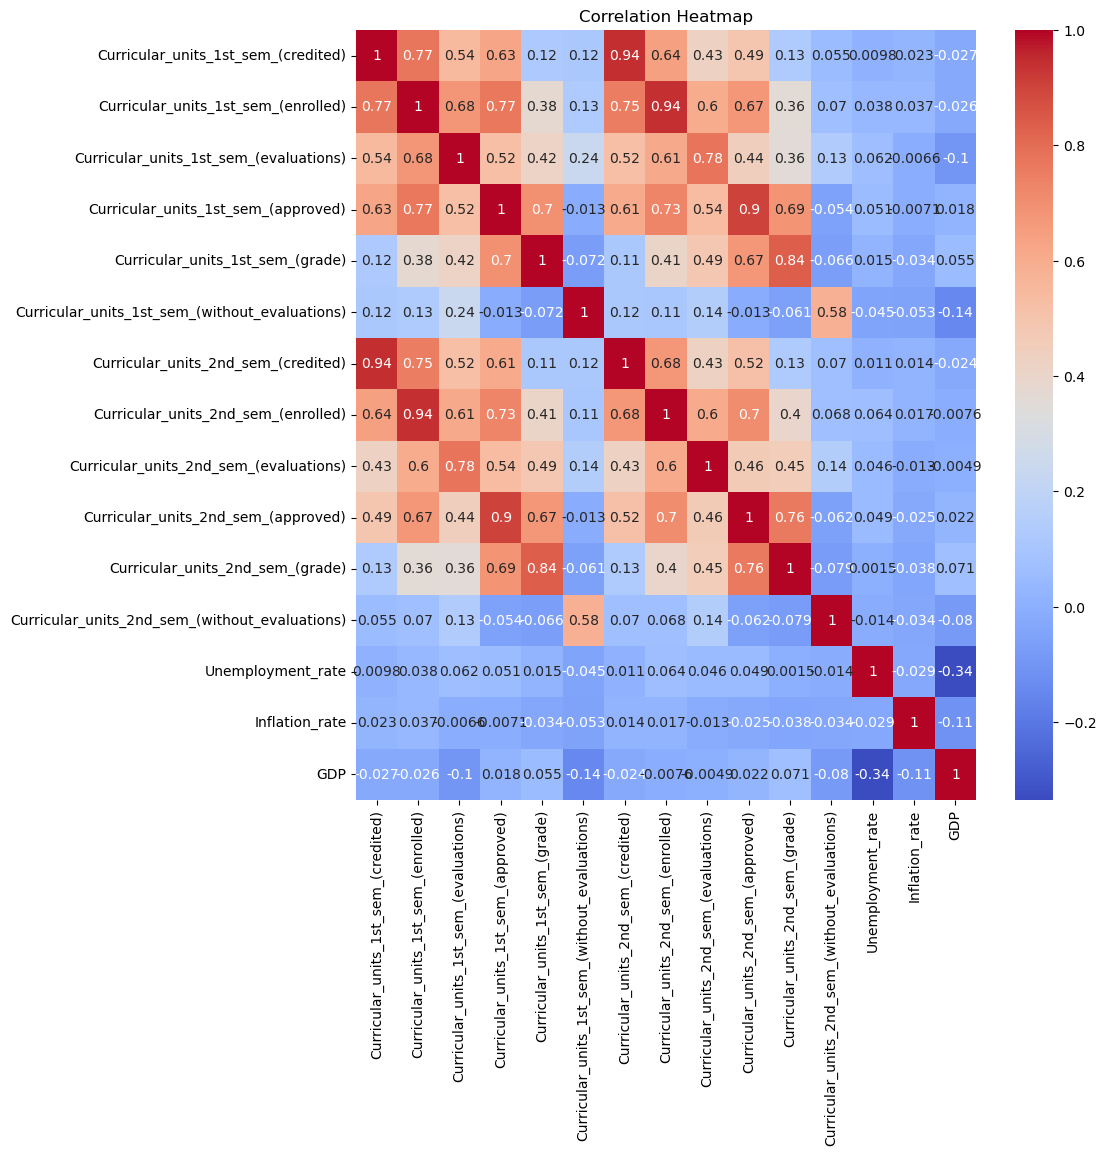

In [61]:
# heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Overall Correlation Strength:
### Some of the correlations in this matrix are strong which provide valuable insights into relationships between variables, but they also come with considerations, especially when building predictive models:


### Let's explore some of the features related to the questions described in the business understanding.

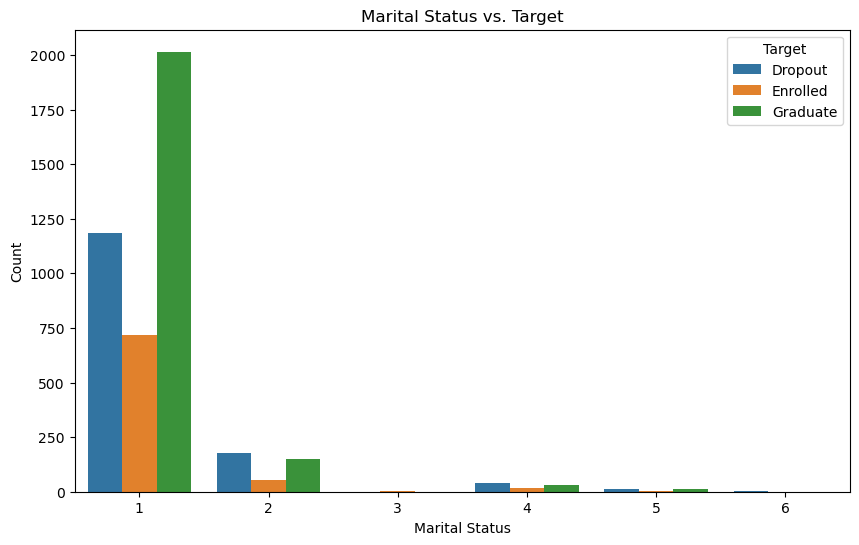

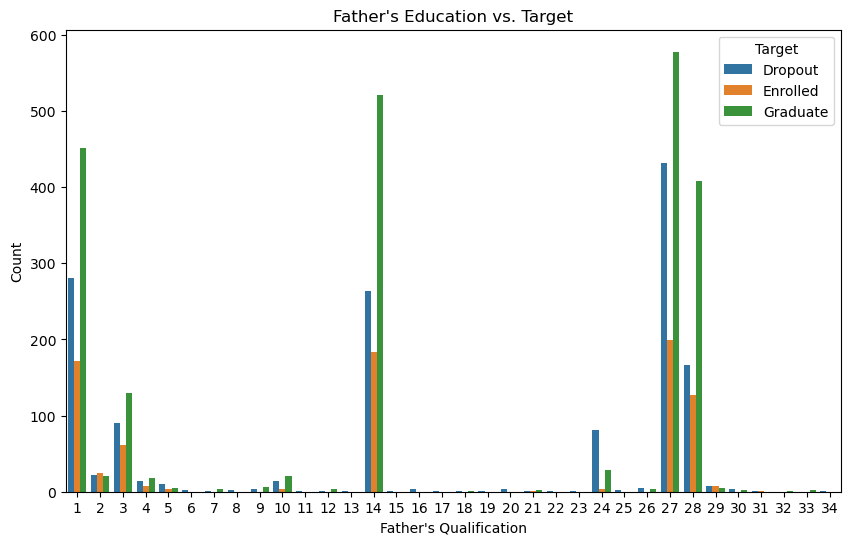

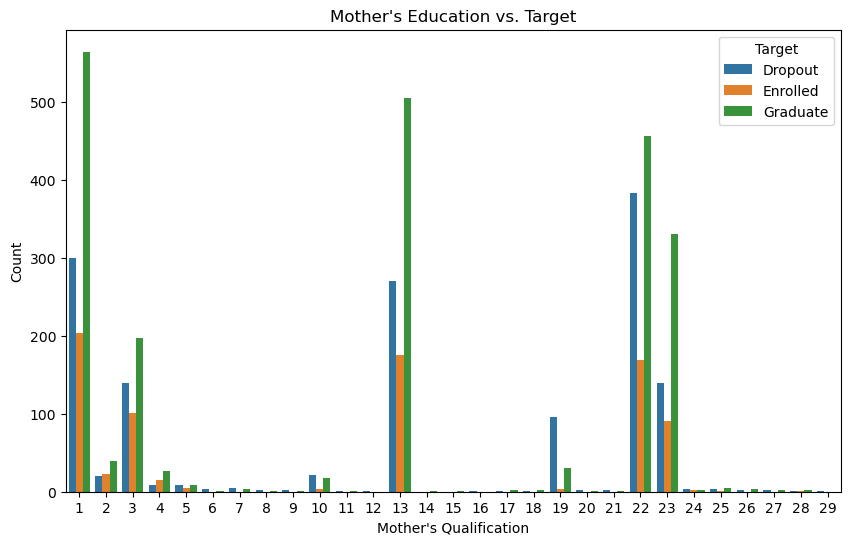

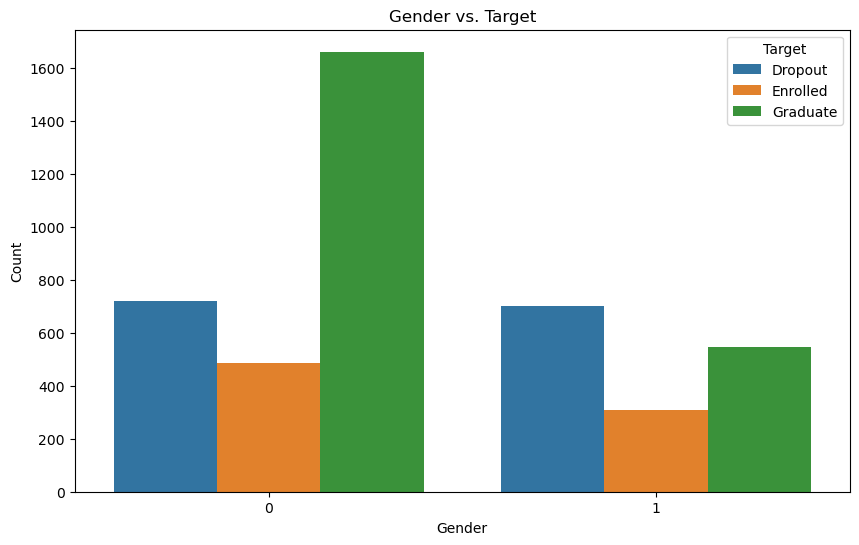

In [62]:

# 1. Marital Status vs. Target
marital_status_table = df.groupby(['Marital_status', 'Target']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=marital_status_table, x='Marital_status', y='Count', hue='Target')
plt.title('Marital Status vs. Target')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

# 2. Father's Education vs. Target
father_education_table = df.groupby(["Father's_qualification", 'Target']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=father_education_table, x="Father's_qualification", y='Count', hue='Target')
plt.title("Father's Education vs. Target")
plt.xlabel("Father's Qualification")
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

# 3. Mother's Education vs. Target
mother_education_table = df.groupby(["Mother's_qualification", 'Target']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=mother_education_table, x="Mother's_qualification", y='Count', hue='Target')
plt.title("Mother's Education vs. Target")
plt.xlabel("Mother's Qualification")
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

# 4. Gender vs. Target
gender_table = df.groupby(['Gender', 'Target']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=gender_table, x='Gender', y='Count', hue='Target')
plt.title('Gender vs. Target')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()


### Overall, marital status, parental education levels, and gender are relevant factors influencing dropout rates.

## 3.Data Preparation



### The primary goal of this analysis is to explore which features influence student dropouts. Since the target variable has three categories—dropout, graduate, and enrolled—it makes sense to exclude the enrolled category to simplify the analysis process and reduce potential class imbalance.

In [63]:
df_filtered = df[df['Target']!='Enrolled']
df_filtered.head()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Nacionality,Mother's_qualification,Father's_qualification,Mother's_occupation,Father's_occupation,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_(credited),Curricular_units_1st_sem_(enrolled),Curricular_units_1st_sem_(evaluations),Curricular_units_1st_sem_(approved),Curricular_units_1st_sem_(grade),Curricular_units_1st_sem_(without_evaluations),Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without_evaluations),Unemployment_rate,Inflation_rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Since Target is now a binary categorical variable, we can use binary encoding.

In [64]:
df_filtered['Target'] = df_filtered['Target'].map({'Dropout': 1, 'Graduate': 0})


In [66]:
df_filtered['Target'].value_counts()

Target
0    2209
1    1421
Name: count, dtype: int64

### The target variable presents a moderate level of class imbalance. To quantify the imbalance ration we divide the number of instance in majority class by the number of instances in minority class. Where the majority class appears to be 1.55 larger times than the minority class. Prior to fitting a ML model, is important to notice that class imbalance can pose challenges as they may become biased towards the majority class. This can lead to poor performance on the minority class.

In [69]:
df_filtered['Target'].value_counts()[0]/df_filtered['Target'].value_counts()[1]

1.5545390570021111

### Creating a function to process data for ML algorithm in the Modeling stage.


In [105]:
# Preprocess the data (One-Hot Encoding for categorical features)
def preprocess_data(df, features):
    """
    Encodes categorical features in a DataFrame using one-hot encoding.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the features.
        features (list): A list of feature names to be encoded.

    Returns:
        pandas.DataFrame: A new DataFrame containing the encoded features.
    """
    
    encoder = OneHotEncoder(drop='first') 
    encoded_features = encoder.fit_transform(df[features])
    feature_names = encoder.get_feature_names_out(features)
    encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names, index=df.index)
    
    return encoded_df

## 4.Data Modeling

### We can now run some statistical test to see if what we observed in the EDA process has a statistical significance. We can leverage a Chi-Square test. This test is a statistical test used to determine if there is a significant association between two categorical variables. It's often used to analyze relationships between variables in contingency tables

In [89]:
import pandas as pd
from scipy.stats import chi2_contingency
import warnings

def chi_squared_test(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof

def calculate_chi_squared_tests(df, features, target):
    results = {}
    for feature in features:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            chi2, p, dof = chi_squared_test(df, feature, target)
        
        results[feature] = {'chi2': chi2, 'p-value': p, 'dof': dof}
        print(f'Chi-Squared Test for {feature}:')
        print(f'Chi2: {chi2:.4f}, p-value: {p:.4f}, Degrees of Freedom: {dof}')
        
        # Interpret the results
        alpha = 0.05  # Significance level
        if p < alpha:
            print(f"The association between {feature} and {target} is statistically significant (p < {alpha}).")
        else:
            print(f"There is no statistically significant association between {feature} and {target} (p >= {alpha}).")
        
        print()  # Add a blank line for readability
    
    return results

# Define the features you want to test
features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]

# Run chi-squared tests
chi_squared_results = calculate_chi_squared_tests(df_filtered, features, 'Target')

# Optional: Sort results by chi-squared statistic
sorted_results = sorted(chi_squared_results.items(), key=lambda x: x[1]['chi2'], reverse=True)
print("\nFeatures sorted by chi-squared statistic:")
for feature, result in sorted_results:
    print(f"{feature}: Chi2 = {result['chi2']:.4f}, p-value = {result['p-value']:.4f}")


Chi-Squared Test for Marital_status:
Chi2: 53.1314, p-value: 0.0000, Degrees of Freedom: 5
The association between Marital_status and Target is statistically significant (p < 0.05).

Chi-Squared Test for Father's_qualification:
Chi2: 147.8617, p-value: 0.0000, Degrees of Freedom: 33
The association between Father's_qualification and Target is statistically significant (p < 0.05).

Chi-Squared Test for Mother's_qualification:
Chi2: 143.0143, p-value: 0.0000, Degrees of Freedom: 28
The association between Mother's_qualification and Target is statistically significant (p < 0.05).

Chi-Squared Test for Gender:
Chi2: 229.3515, p-value: 0.0000, Degrees of Freedom: 1
The association between Gender and Target is statistically significant (p < 0.05).


Features sorted by chi-squared statistic:
Gender: Chi2 = 229.3515, p-value = 0.0000
Father's_qualification: Chi2 = 147.8617, p-value = 0.0000
Mother's_qualification: Chi2 = 143.0143, p-value = 0.0000
Marital_status: Chi2 = 53.1314, p-value = 0.00

### The Chi-Squared tests conducted on the dataset show that all four features — Marital Status, Father's Qualification, Mother's Qualification, and **Gender — have statistically significant associations with the target variable. The p-values for each feature are below 0.05, indicating that the relationships observed are unlikely to be due to random chance.Among the features, Gender had the strongest association with the target, as indicated by the highest Chi-Squared statistic (229.35), followed by Father's Qualification (147.86) and Mother's Qualification (143.01). Marital Status showed the weakest, yet still significant, association (53.13). These results suggest that all these categorical factors play a role in influencing the target variable, with Gender having the most pronounced effect.

### Next we can perform a Cramer's V which is a measure of association between two nominal variables that can quantify the strenght of the relationship between two variables.

In [88]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Function to calculate associations for features
def calculate_association_for_features(df, features, target):
    results = {}
    
    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target])
        
        if df[feature].nunique() == 2 and df[target].nunique() == 2:
            # For binary variables, use Phi coefficient
            chi2 = chi2_contingency(contingency_table)[0]
            n = contingency_table.sum().sum()
            phi = np.sqrt(chi2 / n)
            results[feature] = phi
            print(f"Phi coefficient for {feature}: {phi:.4f}")
        else:
            # For multi-category variables, use Cramér's V
            cramer_v = cramers_v(contingency_table)
            results[feature] = cramer_v
            print(f"Cramér's V for {feature}: {cramer_v:.4f}")
    
    return results

# Example usage
# Assuming df_filtered is your DataFrame with clean data
features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]
target = 'Target'

# Calculate association measures for the features
association_results = calculate_association_for_features(df_filtered, features, target)

# Optional: Sort results by association strength
sorted_results = sorted(association_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nFeatures sorted by association strength:")
for feature, value in sorted_results:
    print(f"{feature}: {value:.4f}")


Cramér's V for Marital_status: 0.1210
Cramér's V for Father's_qualification: 0.2018
Cramér's V for Mother's_qualification: 0.1985
Phi coefficient for Gender: 0.2514

Features sorted by association strength:
Gender: 0.2514
Father's_qualification: 0.2018
Mother's_qualification: 0.1985
Marital_status: 0.1210


### The Cramér's V and Phi coefficient tests reveal varying strengths of association between the categorical features and the target variable. Gender exhibits the strongest association with a Phi coefficient of 0.2514, indicating a moderate relationship. Both Father's Qualification (Cramér's V = 0.2018) and Mother's Qualification (Cramér's V = 0.1985) also show moderate associations with the target, while Marital Status has the weakest association (Cramér's V = 0.1210), suggesting a relatively weaker connection. These results highlight that Gender plays the most significant role in influencing the target, followed by parental qualifications, with marital status having a comparatively smaller impact.

## 5.Modeling

### We can create a model that uses the four features (Gender, Father's Qualification, Mother's Qualification, and Marital Status) to predict the target.

In [116]:
# features selection

features = ["Gender", "Father's_qualification", "Mother's_qualification", "Marital_status"]
target = 'Target'

# features processing
X = preprocess_data(df_filtered, features)

# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df_filtered[target], test_size=0.3, random_state=42)

# fitting logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)

# predictionspredicting on test data
y_pred = model.predict(X_test)

# model performance
accuracy_logistic_regression_model = accuracy_score(y_test, y_pred)
print(f"Accuracy for logistic regression model: {accuracy_logistic_regression_model:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy for logistic regression model: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       675
           1       0.53      0.58      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



### We observed the Target variable has a moderate level of class imbalance which migt be the reasong why the model has lower performance on minority class. We can try the SMOTE (Synthetic Minority Over-sampling Technique) or other models like XGBoost to handle the class imbalance.

### SMOTE Approach 


In [115]:

# features selection

features = ["Gender", "Father's_qualification", "Mother's_qualification", "Marital_status"]
target = 'Target'

# features processing
X = preprocess_data(df_filtered, features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for SMOTE implemenation: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy for SMOTE implemenation: 0.6483

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       675
           1       0.54      0.57      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



#### XGBoost Implementation

In [114]:


# Assuming df_filtered is your DataFrame and 'Target' is the target variable
# Define your features and target
features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]
target = 'Target'

# Feature processing
X = preprocess_data(df_filtered, features)
y = df_filtered[target]  # Ensure y is defined correctly

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'
}

# Train the model
xg_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = xg_model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

# Print results
print(f"Accuracy for XGBoost Model: {accuracy:.4f}")
print("Classification Report:")
print(report)


Accuracy for XGBoost Model: 0.6657
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       675
           1       0.58      0.44      0.50       414

    accuracy                           0.67      1089
   macro avg       0.64      0.62      0.62      1089
weighted avg       0.65      0.67      0.65      1089



### 5.Evaluation

| Model                                   | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) |
|-----------------------------------------|----------|----------------|-------------|---------------|----------------|-------------|---------------|
| Logistic Regression (class_weight='balanced') | 0.6465   | 0.73           | 0.69        | 0.71          | 0.53           | 0.58        | 0.55          |
| Logistic Regression with SMOTE          | 0.6483   | 0.73           | 0.70        | 0.71          | 0.54           | 0.57        | 0.55          |
| XGBoost                                 | 0.6657   | 0.70           | 0.81        | 0.75          | 0.58           | 0.44        | 0.50          |


#### Based on the evaluation results, XGBoost is the most favorable model to use for the following reasons:

- Highest Accuracy: XGBoost achieved an accuracy of 0.6657, which is the highest among the models tested. This indicates it has a better overall performance in predicting the target variable.

- Better Recall for Class 0: The recall for class 0 (the negative class) is 0.81, which means XGBoost is effective at correctly identifying most of the negative instances. This is crucial if false negatives are particularly costly or undesirable.

- Reasonable Precision for Class 1: Although the precision and recall for class 1 (the positive class) are lower compared to the recall for class 0, the model still maintains a balance that may be acceptable depending on the context of the problem.

- Robustness: XGBoost is known for its robustness and ability to handle complex relationships in data. It typically performs well with structured data and can manage categorical variables effectively, especially when combined with techniques like one-hot encoding.

#### Given these advantages, XGBoost would likely be the best choice for this particular dataset and predictive task, especially if the goal is to maximize overall accuracy and minimize false negatives. However, the final decision should also consider the specific context of the problem, such as the costs associated with different types of misclassification.

In [99]:


# Assuming df_filtered is your dataframe
X = df_filtered[["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]]
y = df_filtered['Target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       675
           1       0.54      0.51      0.53       414

    accuracy                           0.65      1089
   macro avg       0.62      0.62      0.62      1089
weighted avg       0.64      0.65      0.64      1089



In [110]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Split your data
X = preprocess_data(df_filtered, features)
y = df_filtered[target]  # Assuming 'Target' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'logloss'
}

# Train the model
xg_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred = xg_model.predict(dtest)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)


Accuracy: 0.6492
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       675
           1       0.54      0.57      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



In [93]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling to the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6474

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       675
           1       0.54      0.52      0.53       414

    accuracy                           0.65      1089
   macro avg       0.62      0.62      0.62      1089
weighted avg       0.65      0.65      0.65      1089



In [98]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Train the BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(class_weight='balanced',random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.5996

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.54      0.63       675
           1       0.48      0.69      0.57       414

    accuracy                           0.60      1089
   macro avg       0.61      0.62      0.60      1089
weighted avg       0.64      0.60      0.60      1089



In [94]:
from imblearn.combine import SMOTEENN

# Apply SMOTE with undersampling
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6455

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       675
           1       0.54      0.51      0.52       414

    accuracy                           0.65      1089
   macro avg       0.62      0.62      0.62      1089
weighted avg       0.64      0.65      0.64      1089



In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Preprocess the data (One-Hot Encoding for categorical features)
def preprocess_data(df, features):
    # Use OneHotEncoder for categorical variables with more than 2 unique values
    encoder = OneHotEncoder(drop='first')  # 'drop=first' to avoid multicollinearity
    encoded_features = encoder.fit_transform(df[features])
    
    # Convert to DataFrame
    feature_names = encoder.get_feature_names_out(features)
    encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names, index=df.index)
    
    return encoded_df

# Assuming df is your DataFrame and 'Target' is your target variable
features = ["Gender", "Father's_qualification", "Mother's_qualification", "Marital_status"]
target = 'Target'

# Preprocess the features
X = preprocess_data(df_filtered, features)

# Step 2: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df_filtered[target], test_size=0.3, random_state=42)

# Step 3: Train the logistic regression model
model = LogisticRegression(class_weight='balanced',max_iter=100,random_state=42)
model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 5: Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       675
           1       0.53      0.58      0.55       414

    accuracy                           0.65      1089
   macro avg       0.63      0.63      0.63      1089
weighted avg       0.65      0.65      0.65      1089



In [439]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df[['Father\'s_qualification', 'Mother\'s_qualification', 'Gender', 'Marital_status']]
y = df['Target']  # Already binary (1 or 0)

# One-hot encode categorical features
encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(), ['Father\'s_qualification', 'Mother\'s_qualification', 'Gender', 'Marital_status'])
])
X_encoded = encoder.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table for Marital Status vs. Target
contingency_table = pd.crosstab(df['Marital_status'], df['Target'])

# Perform Chi-Squared test
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f'Chi2: {chi2}, p-value: {p}, Degrees of Freedom: {dof}')


In [87]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def calculate_association_for_features(df, features, target):
    results = {}
    for feature in features:
        contingency_table = pd.crosstab(df[feature], df[target])
        
        if df[feature].nunique() == 2 and df[target].nunique() == 2:
            # For binary variables, use Phi coefficient
            chi2 = chi2_contingency(contingency_table)[0]
            n = contingency_table.sum().sum()
            phi = np.sqrt(chi2 / n)
            results[feature] = phi
            print(f"Phi coefficient for {feature}: {phi}")
        else:
            # For multi-category variables, use Cramér's V
            cramer_v = cramers_v(contingency_table)
            results[feature] = cramer_v
            print(f"Cramér's V for {feature}: {cramer_v}")
    
    return results

# Define the features you want to test
features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]

# Calculate association measures for the features
association_results = calculate_association_for_features(df_filtered, features, 'Target')

# Optional: Sort results by association strength
sorted_results = sorted(association_results.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nFeatures sorted by association strength:")
for feature, value in sorted_results:
    print(f"{feature}: {value}")

Cramér's V for Marital_status: 0.1209824374154157
Cramér's V for Father's_qualification: 0.2018248045889956
Cramér's V for Mother's_qualification: 0.19848898041626287
Phi coefficient for Gender: 0.251360764941672

Features sorted by association strength:
Gender: 0.251360764941672
Father's_qualification: 0.2018248045889956
Mother's_qualification: 0.19848898041626287
Marital_status: 0.1209824374154157


In [83]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, pearsonr

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

def phi_coefficient(x, y):
    return pearsonr(x, y)[0]

def bin_variable(series, bins=5):
    if pd.api.types.is_categorical_dtype(series):
        # For categorical data, we'll use rank-based binning
        return pd.qcut(series.cat.codes, q=bins, labels=False, duplicates='drop')
    else:
        # For numeric data, we'll use qcut directly
        return pd.qcut(series, q=bins, labels=False, duplicates='drop')

def calculate_association(df, features, target, bin_qualifications=False):
    results = {}
    for feature in features:
        if bin_qualifications and 'qualification' in feature.lower():
            df[f'{feature}_binned'] = bin_variable(df[feature])
            feature = f'{feature}_binned'
        
        if df[feature].nunique() == 2 and df[target].nunique() == 2:
            # Use phi coefficient for binary variables
            association = phi_coefficient(df[feature], df[target])
            method = "Phi Coefficient"
        else:
            # Use Cramér's V for categorical variables
            contingency_table = pd.crosstab(df[feature], df[target])
            association = cramers_v(contingency_table)
            method = "Cramér's V"
        
        results[feature] = {'method': method, 'value': association}
        print(f"{method} for {feature}: {association}")
    
    return results

# Example usage
# Assuming df is your DataFrame
features = ["Marital_status", "Father's_qualification", "Mother's_qualification", "Gender"]
target = 'Target'

# Calculate associations
results = calculate_association(df, features, target, bin_qualifications=True)

# Optional: Sort results by association strength
sorted_results = sorted(results.items(), key=lambda x: abs(x[1]['value']), reverse=True)
print("\nFeatures sorted by association strength:")
for feature, result in sorted_results:
    print(f"{feature}: {result['method']} = {result['value']}")

Cramér's V for Marital_status: 0.08467477769739884
Cramér's V for Father's_qualification_binned: 0.08351422955169154
Cramér's V for Mother's_qualification_binned: 0.09640717468113875
Cramér's V for Gender: 0.2296246802568394

Features sorted by association strength:
Gender: Cramér's V = 0.2296246802568394
Mother's_qualification_binned: Cramér's V = 0.09640717468113875
Marital_status: Cramér's V = 0.08467477769739884
Father's_qualification_binned: Cramér's V = 0.08351422955169154


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create and fit the model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic))


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and fit the model
random_forest_model = RandomForestClassifier(random_state=42, class_weight='balanced')

random_forest_model.fit(X_train, y_train)

# Make predictions
y_pred_forest = random_forest_model.predict(X_test)

# Evaluate the model
print("Random Forest Results:")
print(confusion_matrix(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

# Get feature importances
feature_importances = random_forest_model.feature_importances_
features = encoder.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances from Random Forest:")
print(importance_df)


### Wha
1. Does marital status contribute to student Dropout Rates?
2. Are international students less or more likely of Dropping Out?
3. Does parental education prevent Dropout?
4. How does gender relate to Student Dropout?

In [ ]:
(df_filtered.groupby(['Marital_status', 'Target'])['Target'].count()/df_filtered.shape[0]).reset_index(name='Count')


In [ ]:

df_grouped = (df_filtered.groupby(['Gender', 'Target'])['Target'].count()/df_filtered.shape[0]).reset_index(name='Count')

sns.barplot(data=df_grouped, x='Gender', y='Count', hue='Target')

plt.xticks([0, 1], ['Female', 'Male'])

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Target by Gender')
plt.show();

### The visualization above suggests that female students in this dataset are more likely to graduate than male students, while male students exhibit a higher tendency to drop out compared to females. This highlights a potential gender disparity in educational outcomes within the population analyzed.

In [284]:
# Grouping Variables

# Family Factors
family_factors = [
    'Marital_status',
    "Mother's_qualification",
    "Father's_qualification",
    "Mother's_occupation",
    "Father's_occupation",
    'Displaced'
]

# Demographic Factors
demographic_factors = [
    'Nacionality',
    'Gender',
    'Age_at_enrollment',
    'International'
]

# Application Factors
application_factors = [
    'Application_mode',
    'Application_order',
    'Course',
    'Daytime/evening_attendance',
    'Previous_qualification',
    'Scholarship_holder'
]

# Financial and Economic Factors
financial_economic_factors = [
    'Debtor',
    'Tuition_fees_up_to_date',
    'Unemployment_rate',
    'Inflation_rate',
    'GDP'
]

# Educational Engagement
educational_engagement = [
    'Curricular_units_1st_sem_(credited)',
    'Curricular_units_1st_sem_(enrolled)',
    'Curricular_units_1st_sem_(evaluations)',
    'Curricular_units_1st_sem_(approved)',
    'Curricular_units_1st_sem_(grade)',
    'Curricular_units_1st_sem_(without_evaluations)',
    'Curricular_units_2nd_sem_(credited)',
    'Curricular_units_2nd_sem_(enrolled)',
    'Curricular_units_2nd_sem_(evaluations)',
    'Curricular_units_2nd_sem_(approved)',
    'Curricular_units_2nd_sem_(grade)',
    'Curricular_units_2nd_sem_(without_evaluations)'
]

# Target Variable
target_variable = ['Target']


### Hot-Encoding Categorical Variables

In [294]:
cat_columns = df.select_dtypes(include='object').columns.drop('Target')  # Exclude Target
df_encoded = pd.get_dummies(df, 
                             columns=cat_columns, 
                             dummy_na=False, 
                             drop_first=True)

In [295]:
label_encoder = LabelEncoder()
df_encoded['Target_encoded'] = label_encoder.fit_transform(df['Target'])
df_encoded.drop(columns=['Target'], inplace=True)

In [ ]:
df_encoded.shape

### After one-hot encoding, the final dataset has 287 columns and 4424 rows, which provides a ratio of approximately 15.4:1 .This ratio indicates that we have a reasonable number of columns relative to the rows, which is generally acceptable for many modeling tasks.

## 4.Data Modeling

In [ ]:
df_encoded.head()

### Modeling the data to answer question 1 presented in the business understanding section.

In [298]:
selected_columns = [col for col in df_encoded.columns if any(col.startswith(factor + '_') for factor in family_factors)]

In [ ]:
selected_columns

In [308]:
df_filtered = df_encoded[selected_columns+['Target_encoded']]

In [ ]:
df_filtered.head()

In [310]:
X = df_filtered.drop('Target_encoded', axis=1)
y = df_filtered['Target_encoded']

### Split the Data

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Fit a Random Forest Model

In [ ]:

model = RandomForestClassifier(class_weight='balanced', random_state=42)

model.fit(X_train, y_train)



### Evaluate Feature importance

In [ ]:
# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame to hold feature names and their importances
# Filter features with importance greater than 0
importance_df = importance_df[importance_df['Importance'] > 0.01]

# Print the filtered DataFrame
print(importance_df)

# Optionally visualize the filtered feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest Model (Importance > 0)')
plt.show()


In [326]:
y_pred = model.predict(X_test)


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


In [ ]:
df_filtered['Target_encoded'].value_counts(normalize=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance from Random Forest Model')
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### Train the Random Forest Model

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(y_test, y_pred, target_names=['Not Dropped Out', 'Dropped Out'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
# Required imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from xgboost import XGBClassifier

# Split dataset into features (X) and target (y)
X = df_filtered.drop('Dropped_Out', axis=1)
y = df_filtered['Dropped_Out']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance by setting scale_pos_weight
# Calculate the ratio of majority class to minority class
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Create an XGBoost Classifier with scale_pos_weight for imbalance
xgb_model = XGBClassifier(scale_pos_weight=pos_weight, random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Print classification report to see precision, recall, and f1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Precision-Recall Curve and AUC
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Probability of positive class
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
print(f'Precision-Recall AUC: {pr_auc:.4f}')

# Feature importance using built-in XGBoost feature importance method
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title('Top 10 Feature Importance')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')

model.fit(X_train, y_train)


### Evaluate Feature Importance

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a larger figure
plt.figure(figsize=(12, 6))  # Adjust the figsize as needed

# Plot the feature importances
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)  # Rotate x-axis labels by 45 degrees
plt.xlim([-1, X.shape[1]])
plt.xlabel("Features")  # Optional: Add x-axis label
plt.ylabel("Importance")  # Optional: Add y-axis label
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


In [ ]:
# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(feature_importance_df)

In [85]:
### Making predicitons

In [86]:
# Make predictions
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


In [ ]:
# Step 1: One-Hot Encoding categorical variables
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_encoded = pd.get_dummies(df.drop(columns=['Dropped_Out']), dummy_na=True,drop_first=True)  # Drop target and encode
y = df['Dropped_Out']

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
df['Dropped_Out'].value_counts(normalize=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# Splitting your data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Dropped_Out'], test_size=0.2, random_state=42)

# Random Forest with class_weight='balanced'
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test)
y_prob_rf = rf_classifier.predict_proba(X_test)[:, 1]

# Model evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Random Forest AUC-ROC:", roc_auc_score(y_test, y_prob_rf))


In [117]:
#df['Dropped_Out'] = df['Dropped_Out'].map({'Yes': 1, 'No': 0})
y_train = y_train.map({'Yes':1,'No':0})
y_test  = y_test.map({'Yes':1,'No':0})

In [ ]:
from imblearn.over_sampling import SMOTE

# Oversample with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# XGBoost with oversampled data
xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_resampled, y_resampled)

# Predictions
y_pred_xgb_smote = xgb_classifier.predict(X_test)
y_prob_xgb_smote = xgb_classifier.predict_proba(X_test)[:, 1]

# Model evaluation
print("XGBoost (with SMOTE) Classification Report:")
print(classification_report(y_test, y_pred_xgb_smote))

print("XGBoost (with SMOTE) Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_smote))

print("XGBoost (with SMOTE) AUC-ROC:", roc_auc_score(y_test, y_prob_xgb_smote))


In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Assuming 'dropout' is your target variable and `df` is your DataFrame
X = df_filtered.drop('Dropped_Out', axis=1)
y = df_filtered['Dropped_Out']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add constant for logistic regression
X_train_const = sm.add_constant(X_train)

# Fit the model
model = sm.Logit(y_train, X_train_const).fit()

# Summary of the logistic regression model
print(model.summary())
